# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [2]:
# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        #Mean Variance
        self.mean = np.mean(X)
        self.var = np.var(X)
        # variance cannot be 0
        if self.var == 0:
            self.var = 1e-6
        
    def get_probability(self, val):
        #return probility
        return 1 / (self.var * pow(2 * np.pi, 0.5)) * np.exp(-((val - self.mean) ** 2) / (2 * self.var))

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        t = {}
        # X probility
        for i in np.unique(X):
            # Laplacian smoothing to smoothing the dataset
            t[i] = (len(X==i)+1)/(len(X)+2)
        #save probility
        self.prior = t
    def get_probability(self, val):
        # each val Returns the corresponding conditional probability 
        return np.array(list(map(lambda x:self.prior[x] if x in self.prior.keys() else 1,val)))

# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        t = {}
        for i in np.unique(X):
            t[i] = (len(X==i)+1)/(len(X)+len(np.unique(X)))
        self.prior = t
    def get_probability(self, val):
        return np.array(list(map(lambda x:self.prior[x] if x in self.prior.keys() else 1,val)))
        
        

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [17]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        self.feature_types = feature_types
        self.num_classes = num_classes
        
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        #y
        classes = np.unique(y)
        #y probility
        classes_prior = {}
        for class_ in classes:
            classes_prior[class_] = sum(y==class_)/len(y)
        #condition probility
        prior = {}
        #each feature
        for i in range(X.shape[1]):
            #different function for different frature
            if self.feature_types[i] == 'b':
                #without y
                for class_ in classes:
                    #apply
                    temp = BinFeatureParam()
                    #estimate the data
                    temp.estimate(X[y==class_,i])
                    #save probility
                    prior[(class_,i)] = temp
                    
            elif self.feature_types[i] == 'r':
                for class_ in classes:
                    temp = ContFeatureParam()
                    temp.estimate(X[y==class_,i])
                    prior[(class_,i)] = temp
                    
            else:
                for class_ in classes:
                    temp = CatFeatureParam()
                    temp.estimate(X[y==class_,i])
                    prior[(class_,i)] = temp
        #save the result
        self.classes = classes
        self.classes_prior = classes_prior
        self.prior = prior
 
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        #use arry save y probility
        pred = np.ones((X.shape[0],len(self.classes)))
        n = 0
        #y probility
        for class_ in self.classes:
            #muliple y
            pred[:,n] = pred[:,n]*self.classes_prior[class_]
            #caluculate x uder condition
            for i in range(X.shape[1]):
                pred[:,n] = pred[:,n]*self.prior[(class_,i)].get_probability(X[:,i])
            n += 1
        # = 1
        pred = pred/np.sum(pred,axis=1)[:, None]
        #maximun return
        return np.array(list(map(lambda x:self.classes[x],np.argmax(pred,axis=1))))

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 0.9666666666666667


## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [5]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    N, D = X.shape
    for i in range(1,num_splits+1):
        Ntrain = int((1/num_splits*i) * N)
        temp_nbc = []
        temp_lr = []
        for j in range(num_runs):
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain]]
            ytrain = y[shuffler[:Ntrain]]
            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]
            if  Ntrain == N:
                Xtest = X[shuffler[:Ntrain]]
                ytest = y[shuffler[:Ntrain]]
            nbc.fit(Xtrain, ytrain)
            yhat = nbc.predict(Xtest)
            temp_nbc.append(1-np.mean(yhat == ytest))
            lr.fit(Xtrain, ytrain)
            yhat = lr.predict(Xtest)
            temp_lr.append(1-np.mean(yhat == ytest))
        tst_errs_nbc[i-1] = np.mean(temp_nbc)
        tst_errs_lr[i-1] = np.mean(temp_lr)
            
            
    return tst_errs_nbc, tst_errs_lr
    

The utility function below defines the function for plotting. 

In [6]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB


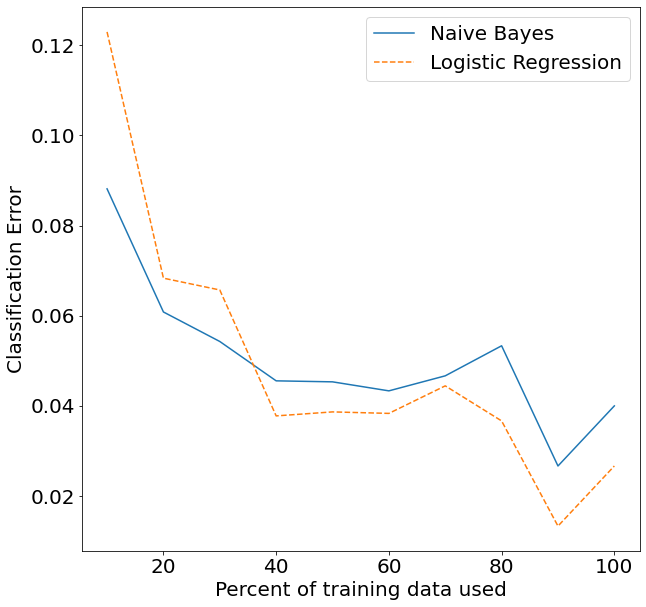

In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings('ignore')
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.info()
X = iris[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].values
y = iris['species'].values
lr_iris = LogisticRegression()
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
tst_errs_nbc_iris, tst_errs_lr_iris = compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_iris, tst_errs_lr_iris, title=None)

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

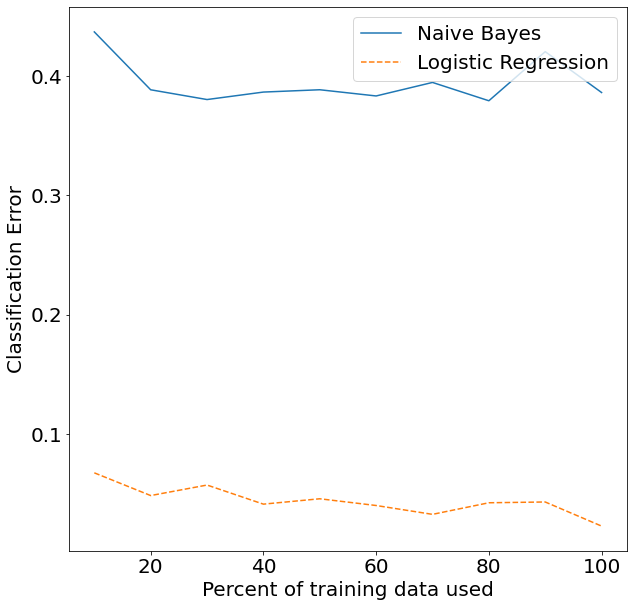

In [8]:
from sklearn.preprocessing import LabelEncoder
voting = pd.read_csv('./datasets/voting.csv')
voting.info()
X = pd.get_dummies(voting.drop(['label'],axis=1).fillna(0))
le = LabelEncoder()
for col in X.columns:
    X[col] = le.fit_transform(X[col])
X = X.values
y = voting['label'].values
lr_voting = LogisticRegression()
nbc_voting = NBC(feature_types=['c' for i in range(X.shape[1])], num_classes=2)
tst_errs_nbc_voting, tst_errs_lr_voting = compareNBCvsLR(nbc_voting, lr_voting, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_voting, tst_errs_lr_voting, title=None)

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buying         1728 non-null   object
 1   maint          1728 non-null   object
 2   doors          1728 non-null   object
 3   persons        1728 non-null   object
 4   lug_boot       1728 non-null   object
 5   safety         1728 non-null   object
 6   acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


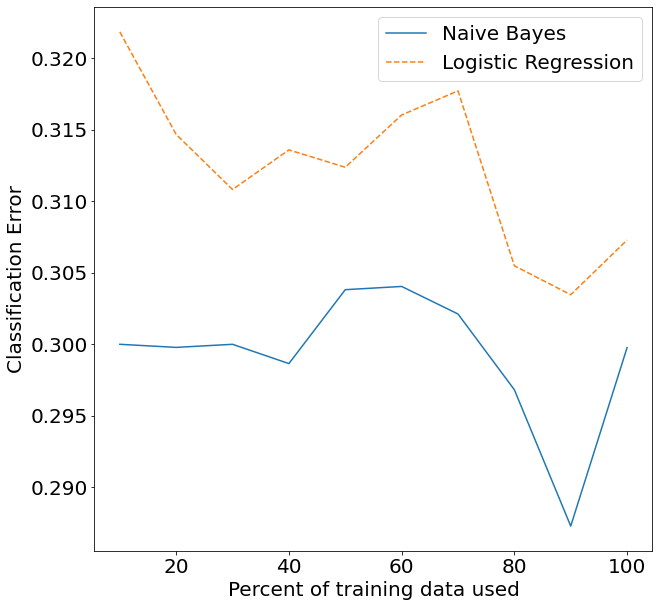

In [9]:
from sklearn.preprocessing import LabelEncoder
car = pd.read_csv('./datasets/car.csv')
car.info()
X = car.drop(['acceptability'],axis=1)
le = LabelEncoder()
for col in X.columns:
    X[col] = le.fit_transform(X[col])
X = X.values
y = car['acceptability'].values
lr_car = LogisticRegression()
nbc_car = NBC(feature_types=['c' for i in range(X.shape[1])], num_classes=4)
tst_errs_nbc_car, tst_errs_lr_car = compareNBCvsLR(nbc_car, lr_car, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_car, tst_errs_lr_car, title=None)

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


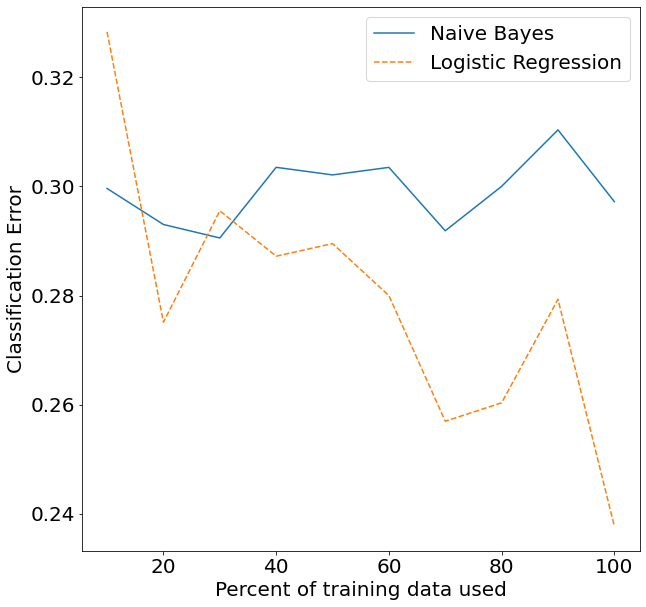

In [10]:
cancer = pd.read_csv('./datasets/breast-cancer.csv')
cancer.info()
X = cancer.drop(['Class'],axis=1)
le = LabelEncoder()
for col in X.columns:
    X[col] = le.fit_transform(X[col])
X = X.values
y = cancer['Class'].values
lr_cancer = LogisticRegression()
nbc_cancer = NBC(feature_types=['c' for i in range(X.shape[1])], num_classes=2)
tst_errs_nbc_cancer, tst_errs_lr_cancer = compareNBCvsLR(nbc_cancer, lr_cancer, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_cancer, tst_errs_lr_cancer, title=None)

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

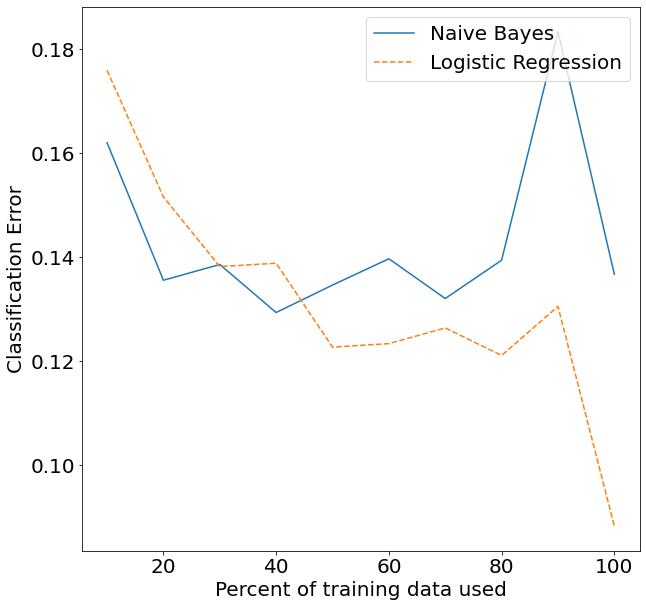

In [12]:
ionosphere = pd.read_csv('./datasets/ionosphere.csv')
ionosphere.info()
X = ionosphere.drop(['label'],axis=1).values
y = ionosphere['label'].values
lr_ionosphere = LogisticRegression()
nbc_ionosphere = NBC(feature_types=['c','c']+['r' for i in range(X.shape[1]-2)], num_classes=2)
tst_errs_nbc_ionosphere, tst_errs_lr_ionosphere = compareNBCvsLR(nbc_ionosphere, lr_ionosphere, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_ionosphere, tst_errs_lr_ionosphere, title=None)

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   208 non-null    float64
 1   feature2   208 non-null    float64
 2   feature3   208 non-null    float64
 3   feature4   208 non-null    float64
 4   feature5   208 non-null    float64
 5   feature6   208 non-null    float64
 6   feature7   208 non-null    float64
 7   feature8   208 non-null    float64
 8   feature9   208 non-null    float64
 9   feature10  208 non-null    float64
 10  feature11  208 non-null    float64
 11  feature12  208 non-null    float64
 12  feature13  208 non-null    float64
 13  feature14  208 non-null    float64
 14  feature15  208 non-null    float64
 15  feature16  208 non-null    float64
 16  feature17  208 non-null    float64
 17  feature18  208 non-null    float64
 18  feature19  208 non-null    float64
 19  feature20  208 non-null    float64
 20  feature21 

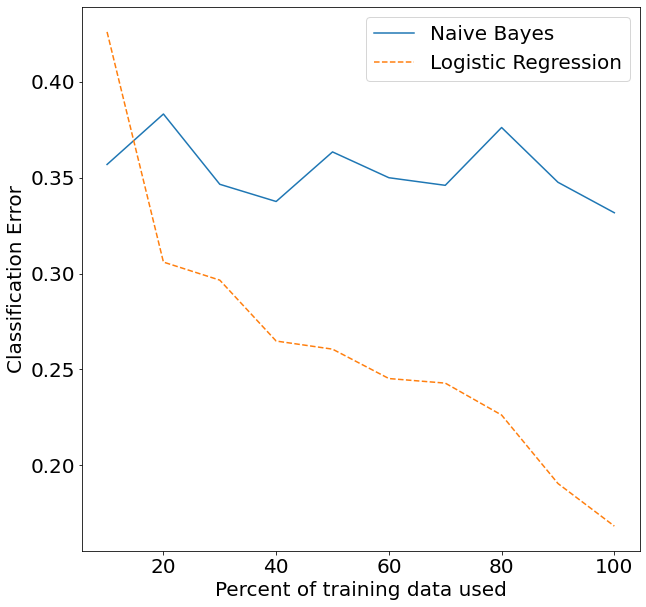

In [13]:
sonar = pd.read_csv('./datasets/sonar.csv')
sonar.info()
X = sonar.drop(['label'],axis=1).values
y = sonar['label'].values
lr_sonar = LogisticRegression()
nbc_sonar = NBC(feature_types=['r' for i in range(X.shape[1])], num_classes=2)
tst_errs_nbc_sonar, tst_errs_lr_sonar = compareNBCvsLR(nbc_sonar, lr_sonar, X, y, num_runs=10, num_splits=10)
makePlot(tst_errs_nbc_sonar, tst_errs_lr_sonar, title=None)

# Practical 2 Report

In practical 2, the hardest part we found is that the first two parts to build the model. The first problem we came up with is how to understand Maximum likelihood estimators. At the begining, we want to solve it in the way that taught by ppt, use log and derivative to calculate the estimat. However, we can only calculate the first tow situation by this method, when it comes to the third one, Distribution for binary features, we can not solve it. We turn to many website to search this kind problem and almost none of them use log to calculate the MLE and build Naïve Bayes Classifier.
many of the code from the CSDN and Github directly use the result of the MLE: $\hat{\sigma^2}=\frac{1}{N}\times\sum_{i=1}^{n}(X_i-\bar{X})^2$ and many of them use Laplacian smoothing, though we think here is not that necessary as we had enough data, we still added it into our code.

After the first part, $p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$ is another problem we came with, we still want to solve this formula step by step to find out the result, and we also get the support of our ideas from Stackoverflow website. As the condition is different and our code always went wrong,then we gave up this way.

Picture drawing part is not that hard and we can get a lot information from the website to taught us. Just finishing the last experiment part we found that the first picture is not consistent with the paper. As the conclusion stated in the paper, the   generative model, for example, Naive Bayes, has higher asymptotic error but given a small data set, it approach its asymptotic error earilier and as the data set gets larger and larger, discriminative model can achieve better result. We found our result opposite and finally found that we miss "1-" in calculating errors.

Pratical 2 is the task our three contribuite most, as the formula are hard for us. We have a chat group and we shall the useful link from different website to provide the best solution,Each group member write this practical code first，Communicating and discussing each one's result and choosing the optimal one solution. COntribution on this project is equilly.

Yilan, Tinghuan, Hongjie